In [ ]:
import os
import numpy as np
#import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
#from tensorflow.keras import metrics

from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#from google.colab import files

Mounted at /content/drive


In [ ]:
main_directory = '/content/drive/MyDrive/TESS_changed'

In [ ]:
# Load data and extract features and labels
#data = pd.read_csv("your_data.csv")
#X = data.drop("emotion", axis=1).values
#y = data["emotion"].values

X= []
Y= []

In [ ]:
# Mapping between folder names and labels
label_mapping = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'pleasant_suprise': 5,
    'sad': 6
}

In [ ]:
# Iterate through each subdirectory (each emotion)
for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)

    if os.path.isdir(folder_path):
        label = label_mapping.get(folder_name, -1)  # -1 if folder name not found in the mapping
        if label != -1:
            # Iterate through each .wav file in the subdirectory
            for filename in os.listdir(folder_path):
                if filename.endswith(".wav"):
                    # Load audio file using librosa
                    audio_path = os.path.join(folder_path, filename)
                    audio, _ = librosa.load(audio_path, sr=None)  # sr=None to preserve the original sampling rate

                    # Extract Mel spectrogram
                    mel_spec = librosa.feature.melspectrogram(y=audio, sr=_, n_mels=64)
                    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                    #mel_spec_db_fixed = librosa.util.fix_length(mel_spec_db, 9600, mode='constant', constant_values=0)

                    mel_spec_db_fixed = librosa.util.fix_length(mel_spec_db, size=960)

                    X.append(mel_spec_db_fixed)
                    Y.append(label)

#print(f"Shape of X before flattening: {X.shape}")

# Convert lists to numpy arrays
X = np.array(X)
Y = np.array(Y)
#X = np.array([x.flatten() for x in X])
#Y = np.array(Y)


# Expand dimensions for Conv2D input
X = np.expand_dims(X, axis=-1)

# Convert labels to categorical if using categorical_crossentropy as the loss
# y = to_categorical(y)


In [ ]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

'''
Y_train = np.reshape(Y_train, (-1, 1))
Y_test = np.reshape(Y_test, (-1, 1))

print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)
'''

'\nY_train = np.reshape(Y_train, (-1, 1))\nY_test = np.reshape(Y_test, (-1, 1))\n\nprint("Shape of Y_train:", Y_train.shape)\nprint("Shape of Y_test:", Y_test.shape)\n'

In [ ]:
'''model = Sequential()

# First convolutional block
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Second convolutional block
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Flatten and feed into dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation="softmax"))

# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])'''

In [ ]:
model = Sequential()

# First convolutional block
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

# Second convolutional block
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())

# Flatten and feed into dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation="softmax"))

# Compile model
#model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy", metrics.Precision(name='precision'), metrics.Recall(name='recall')])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])


# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate the model and access the added metrics
'''loss, accuracy, precision, recall = model.evaluate(X_test, Y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)'''

Epoch 1/10
70/70 [==============================] - 16s 98ms/step - loss: 2.9944 - accuracy: 0.6647 - val_loss: 1.2529 - val_accuracy: 0.6143
Epoch 2/10
70/70 [==============================] - 6s 92ms/step - loss: 0.2498 - accuracy: 0.9228 - val_loss: 0.8409 - val_accuracy: 0.8321
Epoch 3/10
70/70 [==============================] - 6s 90ms/step - loss: 0.1338 - accuracy: 0.9563 - val_loss: 0.3663 - val_accuracy: 0.9518
Epoch 4/10
70/70 [==============================] - 6s 92ms/step - loss: 0.0798 - accuracy: 0.9741 - val_loss: 0.1831 - val_accuracy: 0.9696
Epoch 5/10
70/70 [==============================] - 7s 95ms/step - loss: 0.0614 - accuracy: 0.9839 - val_loss: 0.0707 - val_accuracy: 0.9839
Epoch 6/10
70/70 [==============================] - 7s 98ms/step - loss: 0.0316 - accuracy: 0.9911 - val_loss: 0.0135 - val_accuracy: 0.9964
Epoch 7/10
70/70 [==============================] - 7s 95ms/step - loss: 0.0305 - accuracy: 0.9875 - val_loss: 0.0246 - val_accuracy: 0.9929
Epoch 8/10
7

'loss, accuracy, precision, recall = model.evaluate(X_test, Y_test)\n\nprint("Loss:", loss)\nprint("Accuracy:", accuracy)\nprint("Precision:", precision)\nprint("Recall:", recall)'

In [ ]:

# Evaluate the model on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

report = classification_report(Y_test, Y_pred_classes, target_names=label_mapping.keys())
print("Classification Report:\n", report)

18/18 [==============================] - 0s 22ms/step
Classification Report:
                   precision    recall  f1-score   support

           angry       1.00      1.00      1.00        80
         disgust       1.00      1.00      1.00        80
            fear       1.00      1.00      1.00        80
           happy       1.00      0.99      0.99        80
         neutral       1.00      1.00      1.00        80
pleasant_suprise       0.99      1.00      0.99        80
             sad       1.00      1.00      1.00        80

        accuracy                           1.00       560
       macro avg       1.00      1.00      1.00       560
    weighted avg       1.00      1.00      1.00       560



In [ ]:
'''# Evaluate the model and access the added metrics
loss, accuracy, precision, recall = model.evaluate(X_test, Y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)'''

'# Evaluate the model and access the added metrics\nloss, accuracy, precision, recall = model.evaluate(X_test, Y_test)\n\nprint("Loss:", loss)\nprint("Accuracy:", accuracy)\nprint("Precision:", precision)\nprint("Recall:", recall)'

In [ ]:
'''f1 = f1_score(Y_test, model.predict_classes(X_test), average='micro')

print("F1 Score:", f1)'''

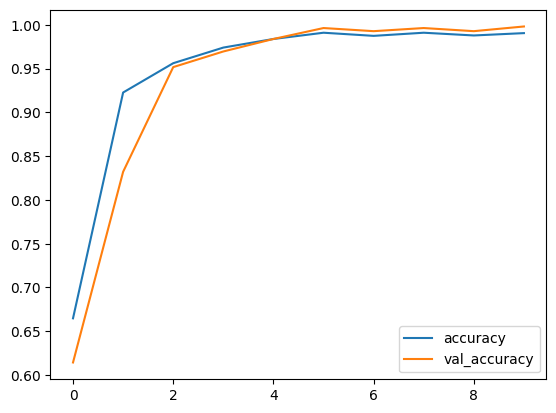

In [ ]:
# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Train the model in smaller batches
'''batch_size = 32
for epoch in range(100):
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size
        model.train_on_batch(X_train[start:end], Y_train[start:end])'''

'batch_size = 32\nfor epoch in range(100):\n    for start in range(0, len(X_train), batch_size):\n        end = start + batch_size\n        model.train_on_batch(X_train[start:end], Y_train[start:end])'

In [ ]:
#model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, _test))


In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

18/18 [==============================] - 0s 23ms/step - loss: 0.0041 - accuracy: 0.9982
Loss: 0.004125236999243498
Accuracy: 0.9982143044471741


In [ ]:
# Load a test audio file
test_audio_path = '/content/drive/MyDrive/test_data/03-02-12-01-13-91-02-02-01-32.wav'
test_audio, _ = librosa.load(test_audio_path, sr=None)

In [ ]:
# Extract Mel spectrogram
test_mel_spec = librosa.feature.melspectrogram(y=test_audio, sr=_, n_mels=64)
test_mel_spec_db = librosa.power_to_db(test_mel_spec, ref=np.max)

In [ ]:
# Fix the length to match your model's input size
test_mel_spec_db_fixed = librosa.util.fix_length(test_mel_spec_db, size=960)

# Expand dimensions for Conv2D input
test_input = np.expand_dims(test_mel_spec_db_fixed, axis=-1)

# Make a prediction using the trained model
predicted_label = np.argmax(model.predict(np.array([test_input])))

# Map the predicted label back to the original emotion
emotion_mapping_reverse = {v: k for k, v in label_mapping.items()}
predicted_emotion = emotion_mapping_reverse[predicted_label]

print(f"Predicted Emotion: {predicted_emotion}")

1/1 [==============================] - 0s 19ms/step
Predicted Emotion: angry


In [ ]:
Audio(test_audio, rate=_)